# OBJETIVO

Desenvolver um modelo de regressão capaz de prever o valor médio das casas na cidade de Boston.

# BIBLIOTECAS

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# BASE DE DADOS DE TREINO

In [185]:
df_train = pd.read_csv('train.csv')
df_train.head()

,ID,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9


In [186]:
df_train.info()
#sem valores nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ID       333 non-null    int64  
 1   crim     333 non-null    float64
 2   zn       333 non-null    float64
 3   indus    333 non-null    float64
 4   chas     333 non-null    int64  
 5   nox      333 non-null    float64
 6   rm       333 non-null    float64
 7   age      333 non-null    float64
 8   dis      333 non-null    float64
 9   rad      333 non-null    int64  
 10  tax      333 non-null    int64  
 11  ptratio  333 non-null    float64
 12  black    333 non-null    float64
 13  lstat    333 non-null    float64
 14  medv     333 non-null    float64
dtypes: float64(11), int64(4)
memory usage: 39.2 KB


In [187]:
df_train.drop(['ID'], axis=1, inplace=True)

# MODELO

In [188]:
#separando treino e teste
X = df_train.drop(['medv'], axis=1)
y = df_train['medv']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#parâmetros para Random Search
param_dist = {
    'n_estimators': [1000, 1050, 1100],
    'learning_rate': [0.01, 0.02, 0.04, 0.05],
    'max_depth': [2, 3, 4, 5],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0.01, 0.02, 0.03, 0.04]
}

#Random Search
random_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=0),
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=0,
    n_jobs=-1
)

#treinar o modelo
random_search.fit(X_train, y_train)

#melhor modelo encontrado
best_model = random_search.best_estimator_

#previsão
y_pred = best_model.predict(X_test)

#avaliação
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
RMSE: 2.9144
MAE: 1.9657
R²: 0.9034


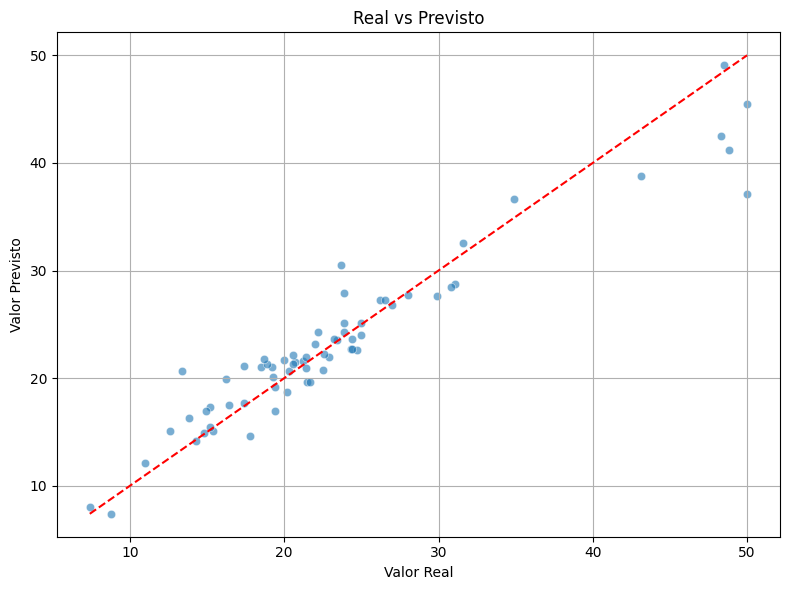

In [190]:
#real vs previsto
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')  # linha ideal
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.title('Real vs Previsto')
plt.grid(True)
plt.tight_layout()
plt.show()

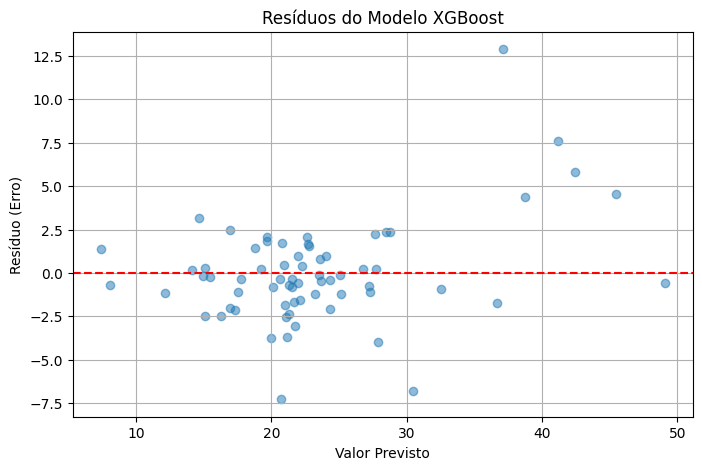

In [191]:
#gráfico dos resíduos (erros de previsão)
residuos = y_test - y_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuos, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valor Previsto')
plt.ylabel('Resíduo (Erro)')
plt.title('Resíduos do Modelo XGBoost')
plt.grid(True)
plt.show()

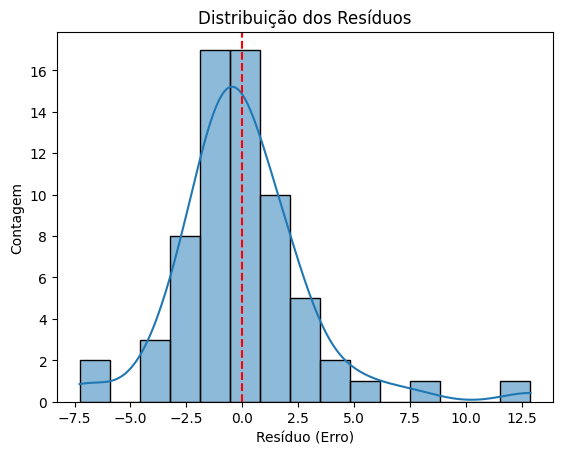

In [192]:
#distribuição dos resíduos
sns.histplot(residuos, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title('Distribuição dos Resíduos')
plt.xlabel('Resíduo (Erro)')
plt.ylabel('Contagem')
plt.show()

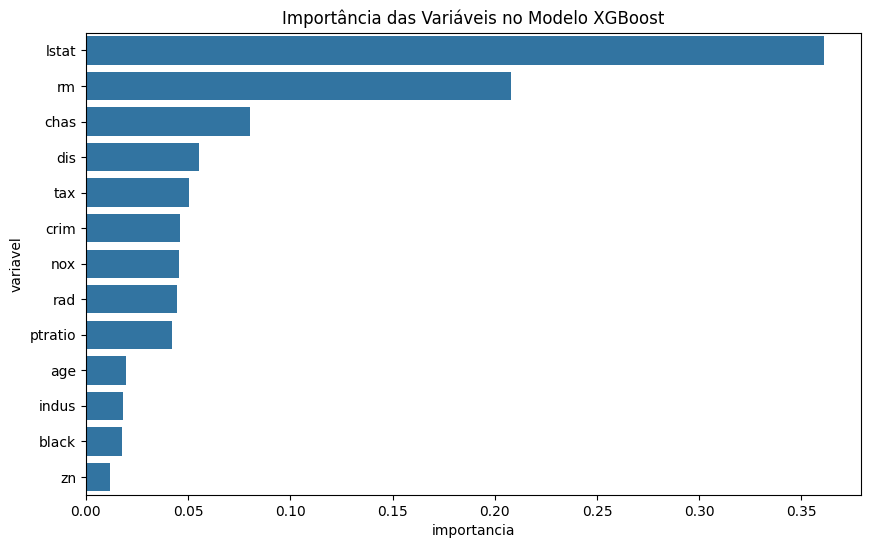

In [193]:
importancia_df = pd.DataFrame({
    'variavel': X_train.columns,
    'importancia': best_model.feature_importances_
})

importancia_ordenada = importancia_df.sort_values(by='importancia', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importancia_ordenada, x='importancia', y='variavel')
plt.title('Importância das Variáveis no Modelo XGBoost')
plt.show()

# BASE DE TESTE

In [194]:
df_test = pd.read_csv('test.csv')
df_test.head()

,ID,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
1,6,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21
2,8,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,396.90,19.15
3,9,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311,15.2,386.63,29.93
4,10,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311,15.2,386.71,17.10


In [195]:
df_test.drop(['ID'], axis=1, inplace=True)

In [196]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     173 non-null    float64
 1   zn       173 non-null    float64
 2   indus    173 non-null    float64
 3   chas     173 non-null    int64  
 4   nox      173 non-null    float64
 5   rm       173 non-null    float64
 6   age      173 non-null    float64
 7   dis      173 non-null    float64
 8   rad      173 non-null    int64  
 9   tax      173 non-null    int64  
 10  ptratio  173 non-null    float64
 11  black    173 non-null    float64
 12  lstat    173 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 17.7 KB


# APLICANDO O MODELO PARA OS NOVOS DADOS

In [197]:
previsoes_df_test = best_model.predict(df_test)
previsoes_df_test

array([33.296864 , 25.429405 , 17.824532 , 12.539434 , 17.72056  ,
       18.105745 , 19.412024 , 15.668487 , 14.893196 , 16.025118 ,
       17.306145 , 19.63347  , 16.20914  , 15.869754 , 22.714466 ,
       22.335762 , 24.005703 , 29.76427  , 13.950239 , 25.410059 ,
       21.853142 , 22.991383 , 20.85483  , 21.09304  , 20.77581  ,
       21.092121 , 23.077505 , 21.823805 , 24.702251 , 26.974413 ,
       38.597237 , 41.20583  , 31.164528 , 20.649837 , 17.995808 ,
       21.293337 , 18.305683 , 18.776861 , 19.549828 , 21.060833 ,
       17.825827 , 19.71282  , 20.147844 , 17.359375 , 15.206793 ,
       15.590803 , 15.567371 , 16.532917 , 19.653267 , 23.406752 ,
       17.547438 , 36.03479  , 48.513897 , 21.871737 , 24.625654 ,
       26.894745 , 30.069437 , 46.00796  , 36.60542  , 31.667223 ,
       30.621126 , 39.986233 , 20.635546 , 18.1795   , 20.410057 ,
       23.220837 , 25.759823 , 23.558031 , 20.441536 , 22.91308  ,
       27.953268 , 42.10132  , 34.34312  , 33.02675  , 24.6526

# SUBMISSÃO

In [198]:
df_test_reload = pd.read_csv('test.csv')
submission = pd.DataFrame({'ID': df_test_reload['ID'], 'medv': previsoes_df_test})

In [199]:
submission.head()

,ID,medv
0,3,33.296864
1,6,25.429405
2,8,17.824532
3,9,12.539434
4,10,17.720560


In [178]:
submission.to_csv('submission.csv', index=False)